# Data Modelarion
## Import Libraries

In [54]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import re
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns

# one hot encoding con feature-engine
#from feature_engine.encoding import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# GroupKFold en un pipeline con StandardScaler y SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, GroupKFold, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

## Import Data

In [55]:
X_train= pd.read_csv('../datasets/processed/X_train.csv', sep=',', encoding='utf-8')
X_test= pd.read_csv('../datasets/processed/X_test.csv', sep=',', encoding='utf-8')
y_test= pd.read_csv('../datasets/processed/y_test.csv', sep=',', encoding='utf-8')
y_train= pd.read_csv('../datasets/processed/y_train.csv', sep=',', encoding='utf-8')

In [56]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of training sets:
X_train: (454, 36)
y_train: (454, 1)

Shapes of testing sets:
X_test: (114, 36)
y_test: (114, 1)


In [66]:
X_train.head(15)

,edad,psa,numero_de_muestras_tomadas,dias_hospitalizacion_mq,dias_hospitalizacion_upc,diabetes,hospitalizacion_ultimo_mes,biopsias_previas,volumen_prostatico,cup,...,agente_aislado_no,agente_aislado_pseudomonas_aeruginosa,patron_de_resistencia_ampi_r_cipro_r_genta_r_sulfa_m_r,patron_de_resistencia_multi_sensible,patron_de_resistencia_no,patron_de_resistencia_resistente_a_ampi_cipro_y_genta,patron_de_resistencia_resistente_all,hospitalizacion_NO,hospitalizacion_SI,hospitalizacion_nan
0,-0.742132,0.078757,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.012720,-0.312913,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.659736,-0.171245,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.418624,-0.468043,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.095116,-0.177656,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.659736,0.303118,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,-0.095116,-0.286631,-0.254351,-0.172889,-0.07175,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,-0.095116,-0.395606,-0.254351,-0.172889,-0.07175,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,-1.173476,-0.594326,-0.254351,1.916491,-0.07175,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,-0.310788,0.367221,-0.254351,-0.172889,-0.07175,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [67]:
y_train.head(15)

,biopsia
0,8.0
1,7.0
2,2.0
3,2.0
4,2.0
5,7.0
6,7.0
7,7.0
8,7.0
9,8.0


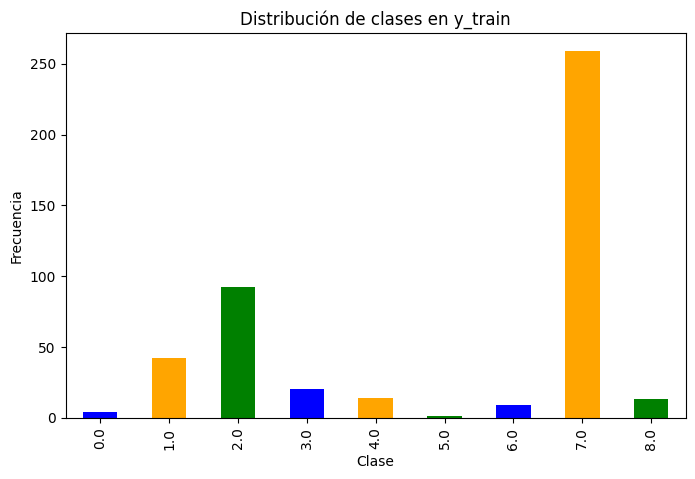

In [64]:
# Crear un gráfico de barras para la columna 'biopsia'
plt.figure(figsize=(8, 5))
y_train['biopsia'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribución de clases en y_train')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

### Procesing Target

In [61]:
# Verificar el balance de clases en los conjuntos de entrenamiento y prueba
print("Distribución de clases en X_train:")
if len(X_train) > 0:
    print(pd.Series(X_train.values.flatten()).value_counts())
else:
    print("El conjunto de entrenamiento está vacío.")

print("\nDistribución de clases en y_train:")
if len(y_train) > 0:
    print(pd.Series(y_train.values.flatten()).value_counts())
else:
    print("El conjunto de prueba está vacío.")


Distribución de clases en X_train:
 0.000000    9987
 1.000000    3659
-0.071750     452
-0.172889     435
-0.254351     338
             ... 
 0.165296       1
 1.642875       1
-0.241759       1
-0.196887       1
 1.303128       1
Name: count, Length: 212, dtype: int64

Distribución de clases en y_train:
7.0    259
2.0     92
1.0     42
3.0     20
4.0     14
8.0     13
6.0      9
0.0      4
5.0      1
Name: count, dtype: int64


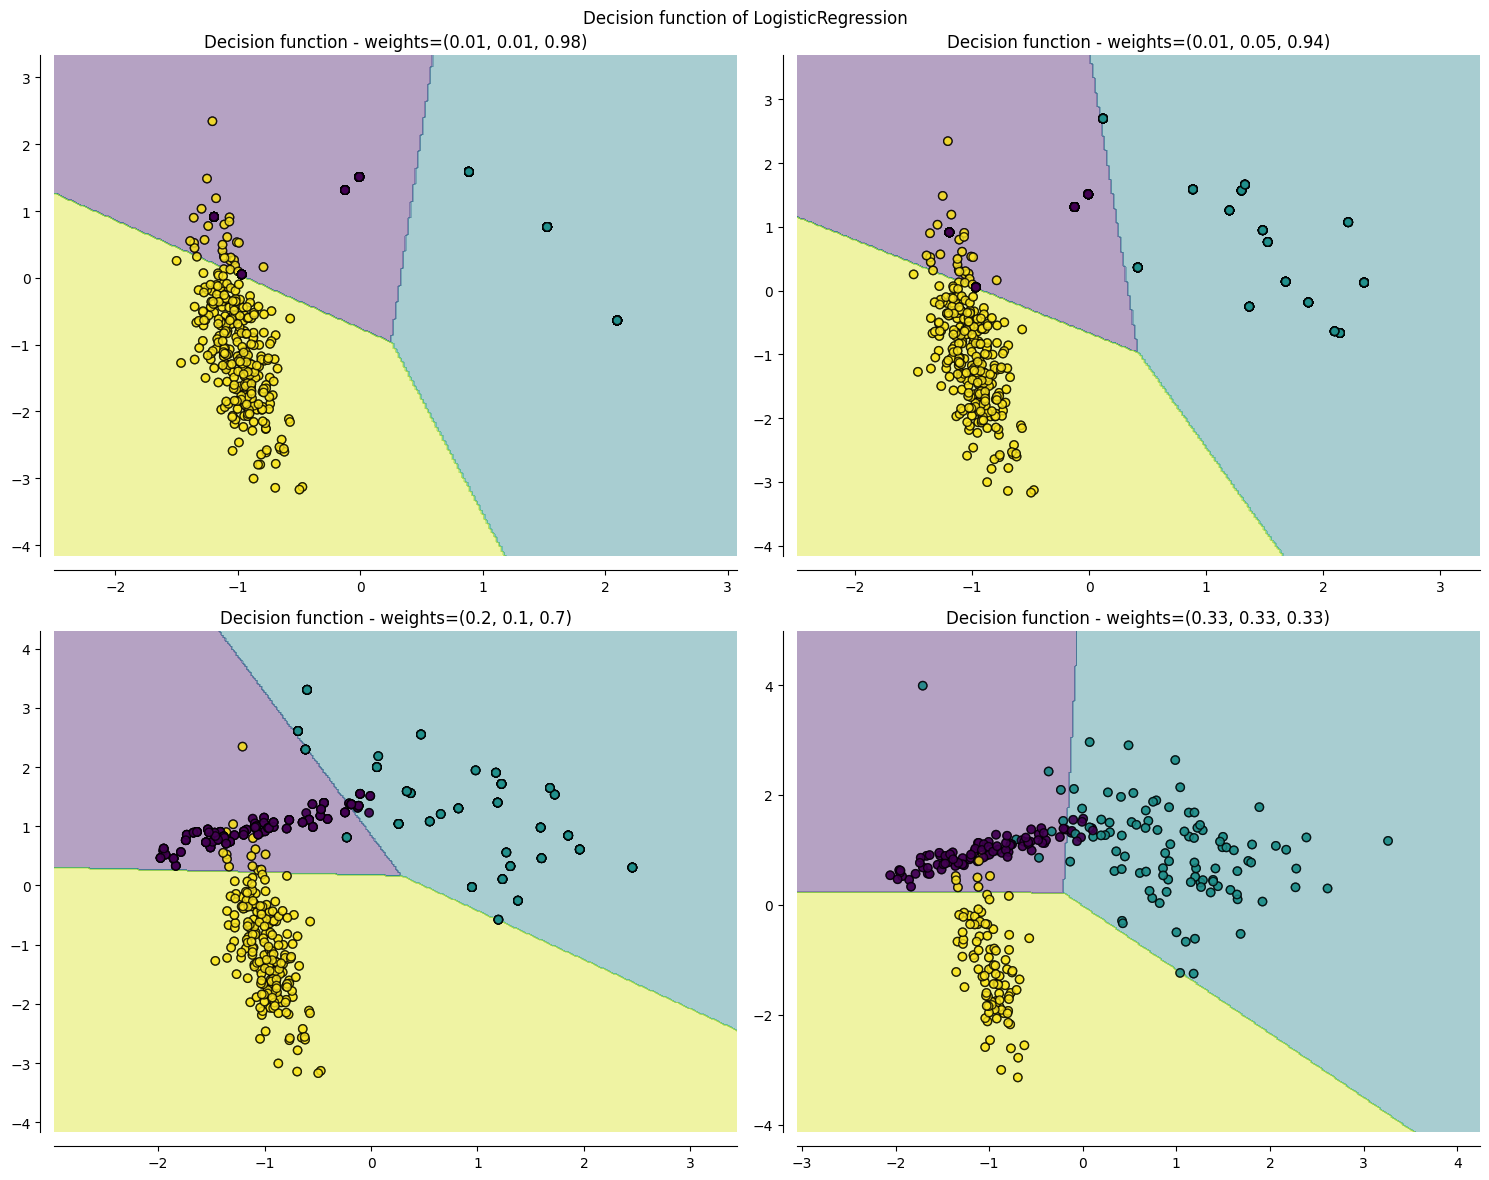

Shapes after oversampling:
X_train_resampled: (879, 2)
y_train_resampled: (879,)
Distribución de clases en y_train_resampled:
2    293
0    293
1    293
Name: count, dtype: int64


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Seed para reproducibilidad
SEED = 42

# Crear un conjunto de datos desbalanceado similar a tu caso
def create_dataset(
    n_samples=1000,
    weights=(0.01, 0.01, 0.98),
    n_classes=3,
    class_sep=1.0,  # Ajusta este valor para cambiar la separación entre clases
    n_clusters=1,
    random_state=None
):
    return make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=random_state,
    )

# Función para visualizar la decisión del clasificador
def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

# Crear un clasificador logistic
clf = LogisticRegression()

# Crear conjuntos de subgráficos
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

weights_arr = (
    (0.01, 0.01, 0.98),
    (0.01, 0.05, 0.94),
    (0.2, 0.1, 0.7),
    (0.33, 0.33, 0.33),
)
# Función para visualizar el resampling
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

# Seleccionar las clases de interés (por ejemplo, clases 0 y 1)
classes_of_interest = (0, 1, 2)

# Almacena los conjuntos oversampleados
oversampled_datasets = []

for ax, weights in zip(axs.ravel(), weights_arr):
    # Crear un conjunto de datos desbalanceado
    X, y = create_dataset(n_samples=300, weights=weights, random_state=SEED)
    
    # Filtrar solo las clases de interés
    filter_classes = np.isin(y, classes_of_interest)
    X = X[filter_classes]
    y = y[filter_classes]
    
    # Aplicar oversampling al conjunto de datos
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=SEED)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Almacenar los conjuntos oversampleados
    oversampled_datasets.append((X_resampled, y_resampled))
    
    # Entrenar el clasificador con el conjunto de datos balanceado
    clf.fit(X_resampled, y_resampled)
    
    # Visualizar el resampling y la decisión del clasificador
    plot_resampling(X, y, oversampler, ax, title=f"Resampling - weights={weights}")
    plot_decision_function(X_resampled, y_resampled, clf, ax, title=f"Decision function - weights={weights}")

fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()
plt.show()

# Ahora puedes acceder a los conjuntos oversampleados según sea necesario
# Por ejemplo, para el primer conjunto oversampleado
(X_resampled_1, y_resampled_1) = oversampled_datasets[0]

# Verificar las formas después del oversampling
print("Shapes after oversampling:")
print("X_train_resampled:", X_resampled_1.shape)
print("y_train_resampled:", y_resampled_1.shape)

# Verificar la distribución de clases después del oversampling
print("Distribución de clases en y_train_resampled:")
print(pd.Series(y_resampled_1).value_counts())

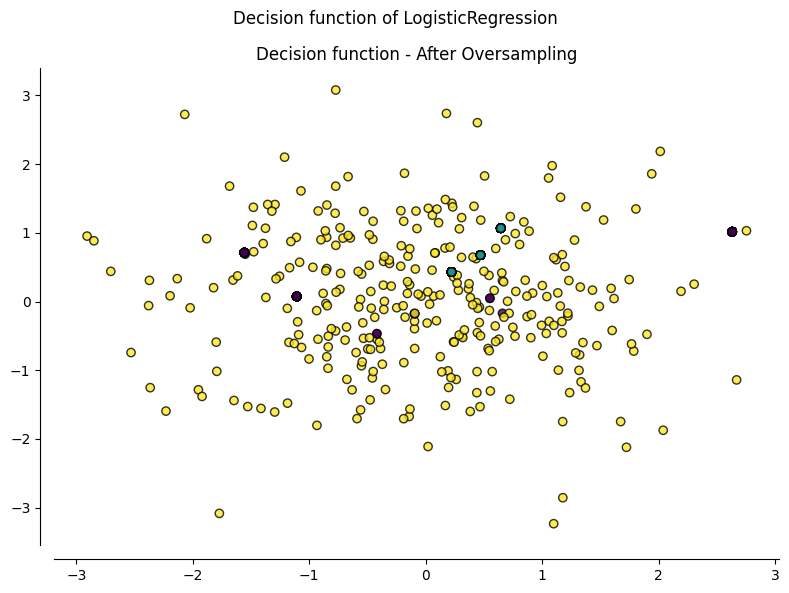

In [79]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    
    # Convertir X_res a DataFrame si no lo es
    if not isinstance(X_res, pd.DataFrame):
        X_res = pd.DataFrame(X_res, columns=X.columns)
    
    ax.scatter(X_res.iloc[:, 0], X_res.iloc[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

# Visualizar la decisión del clasificador
plt.figure(figsize=(8, 6))
plot_resampling(X_train, y_train, oversampler, plt.gca(), title="Resampling - Original Distribution")
plot_decision_function(X_resampled, y_resampled, clf, plt.gca(), title="Decision function - After Oversampling")
plt.suptitle(f"Decision function of {clf.__class__.__name__}")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

# Asumiendo que ya has cargado X_train, y_train, X_test, y_test
# y que has definido SEED

# Especificar la proporción deseada para cada clase
sampling_strategy = {
    0.0: 9,
    1.0: 47,
    2.0: 97,
    3.0: 25,
    4.0: 19,
    5.0: 6,
    6.0: 13,
    7.0: 259,
    8.0: 13  # Ajusta esta proporción para que sea mayor o igual al número original (13)
}

# Crear un objeto RandomOverSampler con la proporción especificada
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)

# Aplicar oversampling a los conjuntos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Mostrar algunos registros originales
df_original = pd.concat([X_train, y_train], axis=1)
print("Registros originales:")
print(df_original.head())

# Mostrar algunos registros sobremuestreados
df_oversampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
print("\nRegistros sobremuestreados:")
print(df_oversampled.head())

# Restaurar el índice si es necesario
df_original.reset_index(drop=True, inplace=True)
df_oversampled.reset_index(drop=True, inplace=True)

# Crear gráficos uno al lado del otro
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Gráfico izquierdo - Original
sns.barplot(x='Class', y='Original', data=data, color='red', label='Original', ax=axs[0])
axs[0].set_title('Class Distribution - Original')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')

# Gráfico derecho - Oversampled
sns.barplot(x='Class', y='Oversampled', data=data, color='green', label='Oversampled', ax=axs[1])
axs[1].set_title('Class Distribution - Oversampled')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

# Ajustar diseño
plt.tight_layout()
plt.show()

Shapes of training sets:
X_train: (454, 36)
y_train: (454, 1)

Shapes of testing sets:
X_test: (114, 36)
y_test: (114, 1)
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


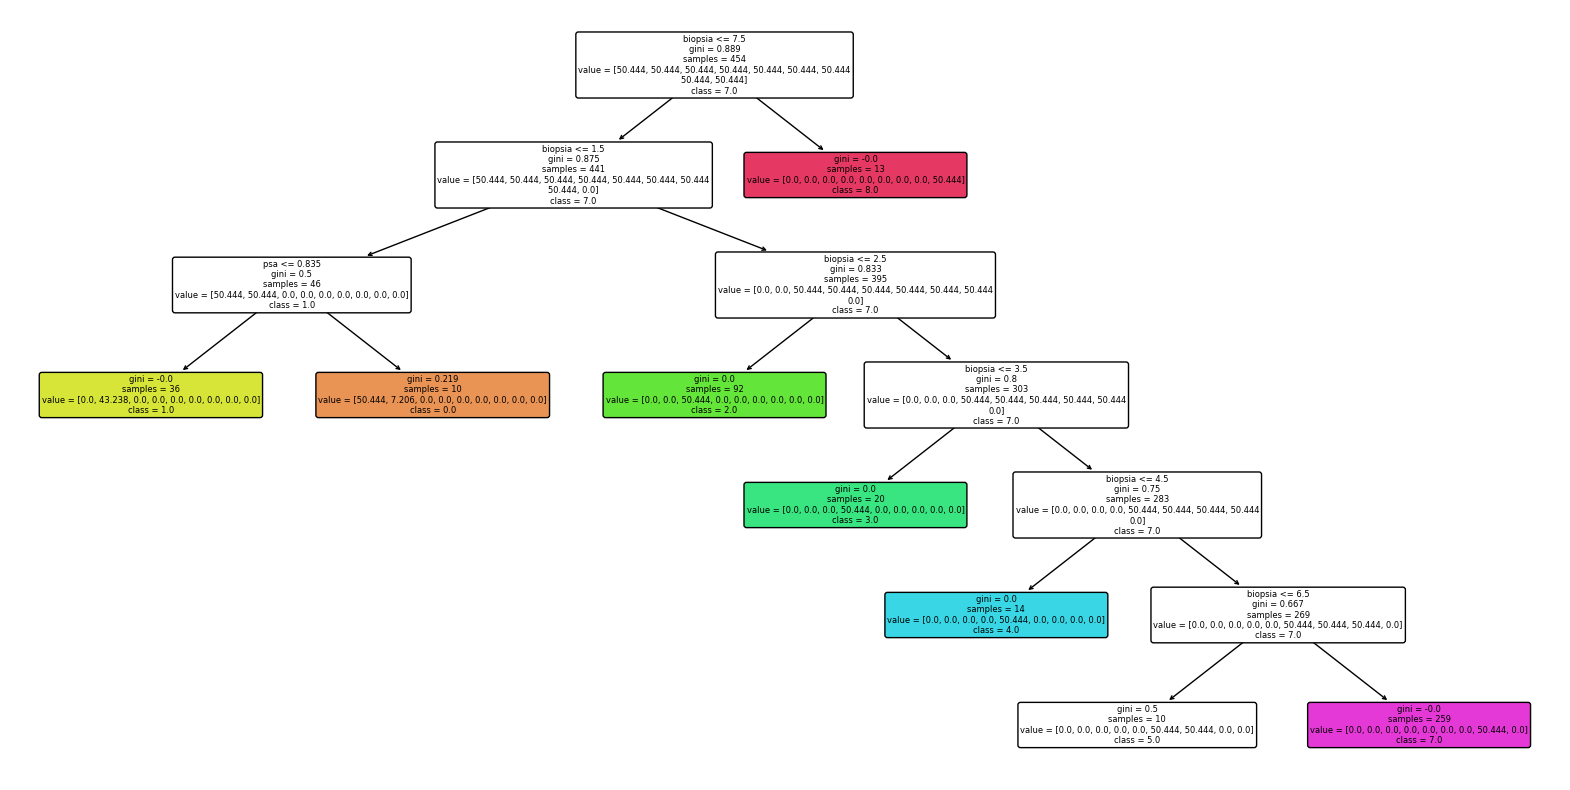

In [34]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
# Configuración de semilla
SEED = 301
np.random.seed(SEED)

def train_and_cross_validate_decision_tree(X_train, y_train, max_depth, min_samples_leaf=None):
    cv = StratifiedKFold(n_splits=10)
    if min_samples_leaf:
        modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=SEED)
    else:
        modelo = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)

    results = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True, scoring='accuracy')
    
    for fold in range(10):
        train_score = results[f'train_score'][fold] * 100
        test_score = results[f'test_score'][fold] * 100
        print(f'Fold {fold + 1}: Árbol max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, training = {train_score:.2f}, testing = {test_score:.2f}')
    
    avg_train_score = results['train_score'].mean() * 100
    avg_test_score = results['test_score'].mean() * 100
    print(f'Average: Árbol max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, average training = {avg_train_score:.2f}, average testing = {avg_test_score:.2f}')
    
    return max_depth, min_samples_leaf, avg_train_score, avg_test_score

# Función para realizar búsqueda de hiperparámetros
# Función para realizar búsqueda de hiperparámetros
def hyperparameter_search(X_train, y_train, espacio_de_parametros):
    buscar = GridSearchCV(DecisionTreeClassifier(random_state=SEED),
                          espacio_de_parametros,
                          cv=KFold(n_splits=5, shuffle=True))

    buscar.fit(X_train, y_train)
    resultados = pd.DataFrame(buscar.cv_results_)
    return resultados, buscar.best_params_


# Función para visualizar el árbol de decisión
# Función para visualizar el árbol de decisión
def visualize_tree(model, features, class_names=None):
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, rounded=True, class_names=class_names, feature_names=features)
    plt.savefig('../datasets/images/tree.png')

espacio_de_parametros = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [10, 12, 14, 16], #16, 32, 64, 128, 256
    'min_samples_split': [2, 5, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'criterion': ['gini', 'entropy']
}


# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train, espacio_de_parametros)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, class_weight='balanced',random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Visualizar el árbol de decisión con los mejores hiperparámetros
visualize_tree(mejor_modelo, X_train.columns, class_names=[str(i) for i in mejor_modelo.classes_])


In [35]:
# Después de ejecutar la búsqueda de hiperparámetros
# Función para realizar búsqueda de hiperparámetros


# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train, espacio_de_parametros)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Mostrar resultados filtrados
resultados_filtrados = resultados_hyperparametros[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]
# Mostrar resultados filtrados ordenados por mean_test_score de mayor a menor
resultados_filtrados_ordenados = resultados_filtrados.sort_values(by='mean_test_score', ascending=False)
print("Resultados filtrados ordenados por mean_test_score de mayor a menor:")
print(resultados_filtrados_ordenados.head(15))

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Resultados filtrados ordenados por mean_test_score de mayor a menor:
    param_max_depth param_min_samples_leaf  mean_test_score  std_test_score
0                 8                     10         0.960391        0.026524
322               8                     10         0.960391        0.026524
82               10                     10         0.960391        0.026524
83               10                     10         0.960391        0.026524
160              12                     10         0.960391        0.026524
161              12                     10         0.960391        0.026524
162              12                     10         0.960391        0.026524
163              12                     10         0.960391        0.026524
240              15                     10         0.960391        0.026524
241              15                   

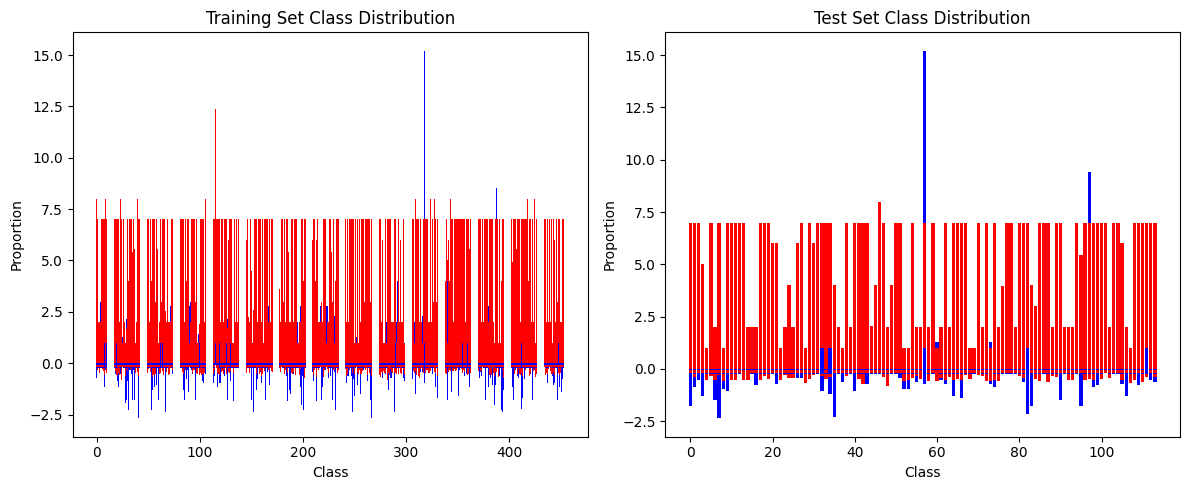

In [36]:
# Convertir las etiquetas de clase a listas
train_class_labels = list(y_train.index)
test_class_labels = list(y_test.index)

# Crear una figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Graficar la distribución de clases en conjunto de entrenamiento
for class_label in train_class_labels:
    class_data = X_train.loc[X_train.index == class_label]
    axes[0].bar(class_label, class_data.values.flatten(), color=['blue', 'red'])

axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Proportion')

# Graficar la distribución de clases en conjunto de prueba
for class_label in test_class_labels:
    class_data = X_test.loc[X_test.index == class_label]
    axes[1].bar(class_label, class_data.values.flatten(), color=['blue', 'red'])

axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()



In [24]:
# Imprimir todas las columnas disponibles
print("Columnas disponibles en resultados_hyperparametros:")
print(resultados_hyperparametros.columns)

# Imprimir los resultados sin filtrar columnas específicas
print("Resultados de búsqueda de hiperparámetros:")
print(resultados_hyperparametros.sort_values(by='mean_test_score', ascending=False))


Columnas disponibles en resultados_hyperparametros:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_max_features',
       'param_min_samples_leaf', 'param_min_samples_split', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')
Resultados de búsqueda de hiperparámetros:
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
391       0.003199  4.002334e-04         0.003797        0.000748   
390       0.004000  8.963410e-04         0.002999        0.000002   
389       0.003598  4.892385e-04         0.003596        0.000488   
388       0.004198  3.996377e-04         0.003198        0.000400   
151       0.003598  7.991316e-04         0.003399        0.000490   
..             ...           ...              ...             ...   
561

In [37]:
from sklearn.model_selection import cross_val_score
from scipy.stats import sem, t
from numpy import mean

# Utilizar validación cruzada estratificada
cv = StratifiedKFold(n_splits=10)

# Realizar validación cruzada para obtener las métricas de rendimiento
cv_scores = cross_val_score(mejor_modelo, X_train, y_train, cv=cv)

# Calcular la precisión media
mean_accuracy = mean(cv_scores) * 100
print(f"Accuracy media {mean_accuracy:.2f}")

# Calcular el intervalo de confianza
confidence = 0.95
n = len(cv_scores)
m = mean(cv_scores)
std_err = sem(cv_scores)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

# Calcular el intervalo de confianza y mostrarlo
intervalo_confianza = (m - h, m + h)
print(f"Intervalo {confidence * 100:.2f}% {intervalo_confianza}")

# Imprimir el modelo entrenado
print(mejor_modelo)



Accuracy media 90.55
Intervalo 95.00% (0.8539823861618973, 0.9569354882342379)
DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, random_state=301)


c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [38]:
from sklearn.metrics import classification_report

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)

# Imprimir informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))


Informe de clasificación:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12
         2.0       1.00      1.00      1.00        24
         3.0       1.00      1.00      1.00         2
         4.0       1.00      1.00      1.00         6
         5.0       0.00      0.00      0.00         1
         6.0       0.83      1.00      0.91         5
         7.0       1.00      1.00      1.00        63
         8.0       1.00      1.00      1.00         1

    accuracy                           0.99       114
   macro avg       0.85      0.88      0.86       114
weighted avg       0.98      0.99      0.99       114



c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ozi\ti\evstack\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
